In [1]:
import pandas as pd
from models.MUSE import MUSE_Ae, MUSE_Assignment, MUSE_Extraction
from data_handling import data_augmentation
import matplotlib.pyplot as plt
import numpy as np
import torch

In [2]:
# Get the data

# data = pd.read_csv("data/GEL_data/catalogues_Ovary_SBS.tsv", sep="\t")

data = pd.read_csv("data/Scenario_1.csv", index_col="Type")

In [3]:
# Augment the data

data_augmented = data_augmentation(X = data, augmentation = 10)


data_augmented.head()


,SP.Syn.Panc-AdenoCA::S.1_aug_0,SP.Syn.Panc-AdenoCA::S.2_aug_0,SP.Syn.Panc-AdenoCA::S.3_aug_0,SP.Syn.Panc-AdenoCA::S.4_aug_0,SP.Syn.Panc-AdenoCA::S.5_aug_0,SP.Syn.Panc-AdenoCA::S.6_aug_0,SP.Syn.Panc-AdenoCA::S.7_aug_0,SP.Syn.Panc-AdenoCA::S.8_aug_0,SP.Syn.Panc-AdenoCA::S.9_aug_0,SP.Syn.Panc-AdenoCA::S.10_aug_0,...,SP.Syn.Panc-AdenoCA::S.991_aug_9,SP.Syn.Panc-AdenoCA::S.992_aug_9,SP.Syn.Panc-AdenoCA::S.993_aug_9,SP.Syn.Panc-AdenoCA::S.994_aug_9,SP.Syn.Panc-AdenoCA::S.995_aug_9,SP.Syn.Panc-AdenoCA::S.996_aug_9,SP.Syn.Panc-AdenoCA::S.997_aug_9,SP.Syn.Panc-AdenoCA::S.998_aug_9,SP.Syn.Panc-AdenoCA::S.999_aug_9,SP.Syn.Panc-AdenoCA::S.1000_aug_9
0,127,87,158,27,57,117,109,61,133,10,...,92,125,218,56,88,150,17,17,202,41
1,86,50,105,26,27,54,63,50,72,6,...,70,55,71,22,41,57,18,13,101,25
2,17,9,31,7,6,9,15,9,11,0,...,16,9,15,4,8,6,2,5,29,5
3,73,49,93,13,18,42,47,42,73,6,...,50,53,108,39,45,76,17,8,105,23
4,53,47,103,27,24,54,68,48,53,15,...,44,34,8,20,35,58,16,23,118,23


In [4]:
# Signature extraction

SIGNATURES = 11

data = data.T
data_augmented = data_augmented.T 

HybridAE = MUSE_Ae.HybridAutoencoder(
    input_dim = 96,
    l_1 = 128,
    z = SIGNATURES,
    refit = False,
    constraint = 'pg'
)

In [5]:
# Train the model for signature extraction

error, S, train_loss, val_loss = MUSE_Extraction.train_model_for_extraction(model = HybridAE,
                                                                            X_aug_multi_scaled = data_augmented,
                                                                            X_scaled = data,
                                                                            signatures = SIGNATURES,
                                                                            epochs = 3000,
                                                                            batch_size = 128,
                                                                            save_to = 'test',
                                                                            iteration = 1,
                                                                            patience = 30)

Epoch 100/3000 - Training Loss: -3100757.120750 - Validation Loss: -24263376.000000
Epoch 200/3000 - Training Loss: -3123113.205250 - Validation Loss: -24438964.000000
Epoch 300/3000 - Training Loss: -3124932.266050 - Validation Loss: -24451822.000000
Early stopping at epoch 327


/home/nicovis/Projects/DeepLearningProject/models/MUSE/MUSE_Extraction.py:177: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path

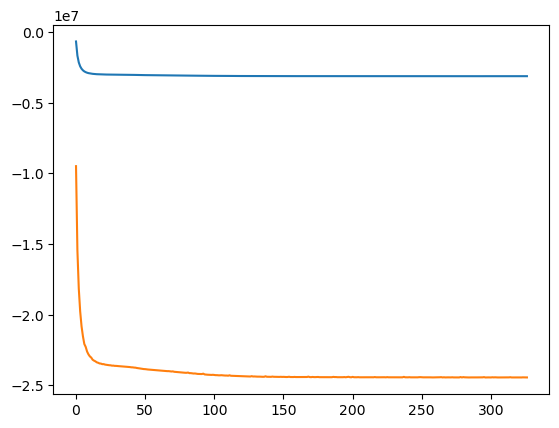

In [6]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.show()

In [7]:


print(np.round(S, 2))

print(error)

[[0.38 0.01 0.08 ... 1.17 2.05 0.  ]
 [0.58 0.   0.04 ... 0.48 1.57 0.01]
 [0.07 0.   0.01 ... 0.17 0.16 0.  ]
 ...
 [0.19 0.   0.32 ... 0.7  0.63 0.07]
 [0.36 0.   0.14 ... 0.49 0.75 0.04]
 [0.74 0.   3.87 ... 0.73 0.83 0.96]]
3391.5376778267237


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Detect device

E = HybridAE.return_encoder_model().to(device)  # Move model to correct device
data_tensor = torch.tensor(data_augmented.values, dtype=torch.float32).to(device)  # Move data to the same device

E = E(data_tensor)  # Perform forward pass

In [9]:
E = E[0].detach().cpu().numpy()  # Move data back to CPU and convert to numpy array

In [10]:
print(np.shape(E))
print(np.shape(S))

Reconstructed = np.dot(E, S.T)

(10000, 11)
(96, 11)


In [11]:
# Frobenius norm between the original and the reconstructed data

error = np.linalg.norm(data_augmented.values - Reconstructed, 'fro')

print(error)

13037.870339733792


In [12]:
print(Reconstructed)

[[157.39056    72.90996    13.039179  ...  33.810276   33.412243
   62.95082  ]
 [ 89.542885   53.998642   10.456029  ...  40.54665    35.6304
   83.163666 ]
 [166.83344   104.48919    22.15882   ...  84.65355    76.80839
  164.31032  ]
 ...
 [ 16.839373   13.496805    2.2024405 ...   7.7144156   8.746915
   14.635471 ]
 [184.75278   105.54315    21.911924  ...  85.289444   73.40191
  189.83192  ]
 [ 45.97504    33.696255    4.3493614 ...  32.685383   24.428766
  265.16568  ]]
